In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date

sns.set(rc = {'figure.figsize':(15,10)})

In [62]:
"""Просмотрим данные о работниках"""

# %%
engineer_meta = pd.read_pickle("./junior_d_meta.pkl")

"""Junior_d_meta:
CITY - город косметолога
REGION1 - информация о гео-локации
REGION2 - информация о гео-локации
REGION3 - информация о гео-локации
CONTACT_ID - ID инженера
SPECIALTY - специализация косметолога
SEGMENT - сегмент косметолога
"""

'Junior_d_meta:\nCITY - город косметолога\nREGION1 - информация о гео-локации\nREGION2 - информация о гео-локации\nREGION3 - информация о гео-локации\nCONTACT_ID - ID инженера\nSPECIALTY - специализация косметолога\nSEGMENT - сегмент косметолога\n'

In [63]:
engineer_meta

,CITY,REGION1,REGION2,REGION3,CONTACT_ID,SPECIALTY,SEGMENT
0,1,-1,-1,-1,021e1902-2efd-40ce-b3ae-8f43703053f7,0,no segment
2,1,-1,-1,-1,028edc7a-9e21-46c1-b34b-6bcd5477c33b,0,no segment
3,1,-1,-1,-1,037c65bb-d5de-4216-a4ed-83b8661dd70c,0,no segment
4,1,-1,-1,-1,040c709e-bb9f-4402-b9b7-74e3e13ff5f9,0,no segment
5,1,-1,-1,-1,04984e54-4e62-47c1-bb3b-d8a985413f40,0,no segment
...,...,...,...,...,...,...,...
26861,122,53,84,806,292e2fb0-56d6-4a16-86b0-158fcbb23481,2,D2
26862,122,53,84,802,19780ba4-8369-4ff1-a4c8-2a93483119bf,2,E
26863,546,43,189,613,9d733733-d5d9-4b34-a1f4-45c000dca5ec,2,A
26864,644,5,413,57,8f16656d-6bd9-4661-b5b8-6dedc3c6f3ac,2,D2


In [64]:
# отсутствуют не уникальные косметологи в таблице
engineer_meta.CONTACT_ID.nunique()

25461

<AxesSubplot:xlabel='CITY', ylabel='Count'>

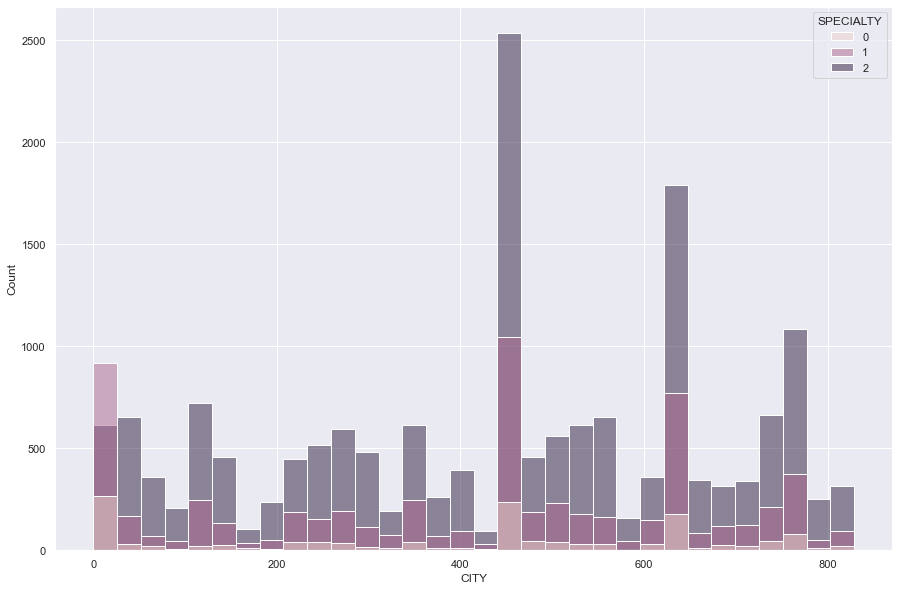

In [65]:
# Можно заметить, что самая распространенная специализация №2, затем идут №1, №0
# Распределение по городам имеет ярко выраженные пики - очевидно столичные города, в провинциях примерно равномерно
sns.histplot(data = engineer_meta,
                        x='CITY',
                        hue='SPECIALTY',
                        kde=False)

<AxesSubplot:xlabel='SEGMENT', ylabel='Count'>

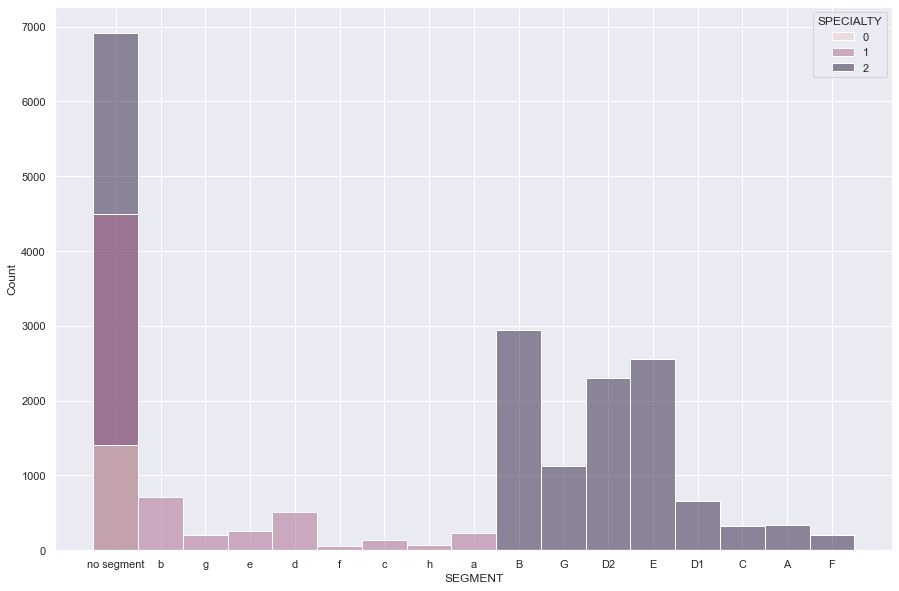

In [66]:
# Самый популярный способ работы - без четкого сегмента, стоит отметить, что косметологи со специальностью №0 не работают с конкретными сегментами клиентов!
sns.histplot(data = engineer_meta,
                        x='SEGMENT',
                        hue='SPECIALTY',
                        kde=False)

In [67]:
# регионы равные -1 относятся только к городу №1, видимо не заполненные анкетные данные
engineer_meta.query('CITY > 1 and REGION1 == "-1"').CITY.count()

0

In [68]:
"""Просмотрим данные о характеристиках писем компании
    Junior_c_meta:
    ID  -  ID email кампании (нет повторов)
    BRANDS - бренды косметики, которые участвуют в рекламной кампании (R 69, A 26, OD 25, O 19, R-OD-O 15)
    KEY_MESSAGE - ключевое сообщение имейла (Other-другое 54, Efficacy-Эффективность 29, Safety-Безопасность 19, Quality-Качество 7, Диагностика 5, Тест 1)
    CONTENT_TYPE - тип контента имейла (Education-Образовательный 70, Engagement-Привлечение партнеров 26, Awareness-Информационное 9, Entertaining-Развлекательное 9)
    CURRENT_STATUS - статус кампании (активный 71/завершенный 42/черновик 41)
"""
company_mail_meta = pd.read_pickle("./junior_c_meta.pkl").rename(columns={'ID':'ID_mail_company'})

In [69]:
company_mail_meta.sort_values("ID_mail_company")

,ID_mail_company,BRANDS,KEY_MESSAGE,CONTENT_TYPE,CURRENT_STATUS
910,93,R,Efficacy,Education,Completed
921,94,O,Quality,Education,Completed
905,97,OD,Quality,Education,Completed
690,98,R,Efficacy,Education,Completed
893,99,O,Efficacy,Education,Completed
...,...,...,...,...,...
565,1201,R,Other,Engagement,Active
560,1203,"R, OD, O",Other,Awareness,Active
299,1205,R,Other,Engagement,Active
127,1207,"R, OD, O",Other,Awareness,Draft


In [70]:
# Черновые проекты не имеют тип контента и ключевого сообщения, за исключением 2х типов писем: ID-557, ID-1207
company_mail_meta.query('CURRENT_STATUS == "Draft"')

,ID_mail_company,BRANDS,KEY_MESSAGE,CONTENT_TYPE,CURRENT_STATUS
3,165,R,None,None,Draft
15,182,R,None,None,Draft
22,557,"R, OD, O",Other,Engagement,Draft
74,416,OD,None,None,Draft
75,266,R,None,None,Draft
81,166,R,None,None,Draft
82,251,O,None,None,Draft
88,318,R,None,None,Draft
91,424,O,None,None,Draft
94,319,R,None,None,Draft


In [71]:
# Вытащим список ID_mail_company из таблицы company_mail_meta для сравнения с ID_mail_company отправленных писем, 
# лишние в последних двух можно убрать, так как по ним нет никакой мета информации.
check_list_id = company_mail_meta.query('CURRENT_STATUS != "Draft"').ID_mail_company.values.tolist()

In [73]:
"""Просмотрим отправленные письма:
    Junior_e_send:
    CONTACT_ID - ID косметолога
    ASSET_ID - ID имейла
    ACTIVITY_TYPE - действие над имейлом
    ACTIVITY_DATE - время совершения действия
    CAMPAIGN_ID - ID email кампании
"""
company_mail_send = pd.read_pickle("./junior_e_send.pkl").rename(columns={'CAMPAIGN_ID':'ID_mail_company'})

In [74]:
company_mail_send.sort_values("ID_mail_company", ascending=False)

,CONTACT_ID,ASSET_ID,ACTIVITY_TYPE,ACTIVITY_DATE,ID_mail_company
135606,61483a91-4dfa-41b1-8ba9-4d84f264a82e,1292,EmailSend,2021-05-29 03:30:20.933,1468.000000000
134956,008407a9-cd68-4e37-9b8e-6eaa1d51299e,1292,EmailSend,2021-05-29 03:30:20.853,1468.000000000
134970,1c6bea78-490a-4271-9f54-25c3e92a61e1,1292,EmailSend,2021-05-29 03:30:19.433,1468.000000000
134969,e9f66deb-1852-4b81-9b82-d2d16bc656ed,1292,EmailSend,2021-05-29 03:30:20.933,1468.000000000
134968,ce8b093b-a64f-4130-9708-a46a48d60493,1292,EmailSend,2021-05-29 03:30:19.433,1468.000000000
...,...,...,...,...,...
50136,ed6f52b2-4b09-46f0-ad0a-0142e378e0ba,None,None,None,None
50137,a3bd9a33-7654-40b5-ae80-945bb5271972,None,None,None,None
50138,5051a6e5-09af-43e6-94af-c362cc21e929,None,None,None,None
50139,cd3753cd-26e7-4bf9-96e6-7283f422557d,None,None,None,None


In [75]:
# пустые строки в таблице отправленых писем вероятно возникли по причине сбоя в отправке - полезной информации не несут, значит можно их удалить!
company_mail_send.isnull().sum()

CONTACT_ID             0
ASSET_ID           23145
ACTIVITY_TYPE      23095
ACTIVITY_DATE      23095
ID_mail_company    23095
dtype: int64

In [76]:
company_mail_send = company_mail_send.fillna(0)
company_mail_send = company_mail_send.query('ID_mail_company > 0')


In [77]:
company_mail_send['ASSET_ID'] = company_mail_send.ASSET_ID.astype(int)
company_mail_send['ID_mail_company'] = company_mail_send.ID_mail_company.astype(int)

In [78]:
# Как видно у всех строк с ASSET_ID=0 был сбой отправки в один момент времени - полезной информации нет, можно удалять.
company_mail_send.query('ASSET_ID == 0')

,CONTACT_ID,ASSET_ID,ACTIVITY_TYPE,ACTIVITY_DATE,ID_mail_company
27755,053bd52e-dbd7-47c1-8a50-8648952ffa03,0,EmailSend,2021-05-01 00:00:00.183,686
27966,06505016-ff6c-490e-8684-4185877f1958,0,EmailSend,2021-05-01 00:00:00.183,686
28005,0321928a-9ca4-4fae-b9e0-8d6ae9b0b48a,0,EmailSend,2021-05-01 00:00:00.183,686
28254,048ae0fa-a55f-45e9-b0f6-93d7f59b962d,0,EmailSend,2021-05-01 00:00:00.183,686
29251,032eb5be-25c8-42c9-87f1-8925cc79a378,0,EmailSend,2021-05-01 00:00:00.183,686
29255,05f8d0ed-21a9-484c-8a9d-531e79a05c3a,0,EmailSend,2021-05-01 00:00:00.183,686
30092,05532b4a-de8e-4d15-9b2b-fcf54be2f23b,0,EmailSend,2021-05-01 00:00:00.183,686
30464,05dc8ce1-42dc-4b5f-afbd-514acec2d465,0,EmailSend,2021-05-01 00:00:00.183,686
30705,037d0cea-0f9f-4ef7-bf06-b32d7aafba9c,0,EmailSend,2021-05-01 00:00:00.183,686
30709,04479c75-ec78-4fb6-900f-b85496ac2923,0,EmailSend,2021-05-01 00:00:00.183,686


In [79]:
#убираем все путсые id
company_mail_send = company_mail_send.query('ASSET_ID > 0')

In [80]:
#convert to datetime format date column
company_mail_send['ACTIVITY_DATE'] = pd.to_datetime(company_mail_send.ACTIVITY_DATE, infer_datetime_format=True)

In [81]:
# добавили колонки с нужными мерами времени
company_mail_send["date_send"] = company_mail_send.ACTIVITY_DATE.dt.date
company_mail_send["weekday_send"] = company_mail_send.ACTIVITY_DATE.dt.weekday
company_mail_send["hour_send"] = company_mail_send.ACTIVITY_DATE.dt.hour

In [82]:
# убираем лишнюю колонку с типом действия
company_mail_send = company_mail_send.drop(columns='ACTIVITY_TYPE')

In [83]:
# убрали id_mail_company о которых нет мета инфы 
company_mail_send  = company_mail_send.loc[company_mail_send.ID_mail_company.isin(check_list_id)]

In [84]:
company_mail_send

,CONTACT_ID,ASSET_ID,ACTIVITY_DATE,ID_mail_company,date_send,weekday_send,hour_send
0,025cb4d9-c8a2-4337-8d52-9fe86642653f,996,2021-04-05 06:47:43.350,1150,2021-04-05,0,6
1,025cb4d9-c8a2-4337-8d52-9fe86642653f,738,2021-02-25 04:02:15.157,976,2021-02-25,3,4
2,025cb4d9-c8a2-4337-8d52-9fe86642653f,740,2021-02-26 03:00:31.030,979,2021-02-26,4,3
3,45997759-279d-4bda-a1d3-f5561cffa025,906,2021-03-17 11:15:00.133,1053,2021-03-17,2,11
4,45997759-279d-4bda-a1d3-f5561cffa025,737,2021-02-25 04:10:16.123,975,2021-02-25,3,4
...,...,...,...,...,...,...,...
117251,037d0cea-0f9f-4ef7-bf06-b32d7aafba9c,1061,2021-04-26 00:00:16.200,1205,2021-04-26,0,0
117252,2354c6a8-d154-4589-bfbc-72d9545d3ea1,1061,2021-04-26 00:00:16.200,1205,2021-04-26,0,0
117253,ea08e448-a8d2-4674-a343-b89e49530756,1061,2021-04-26 00:00:16.200,1205,2021-04-26,0,0
117254,25eb9e2b-0a09-4b1c-a356-f40710a10575,1061,2021-04-26 00:00:16.200,1205,2021-04-26,0,0


In [113]:
count_dublicate = company_mail_send.groupby('ASSET_ID', as_index=False).CONTACT_ID.count()
count_dublicate.rename(columns = {"CONTACT_ID":"count_dublicate"})


,ASSET_ID,count_dublicate
0,218,1902
1,219,636
2,228,615
3,229,1611
4,230,1607
...,...,...
134,1021,1049
135,1053,1468
136,1055,1019
137,1060,1482


In [85]:
# зафиксируем временной интервал, чтобы таблицы посылки и доставки писем были в одном промежутке
max_date = company_mail_send.ACTIVITY_DATE.max()
min_date = company_mail_send.ACTIVITY_DATE.min()

In [108]:
# посчитаем количество уникальных отправленных писем для каждого косметолога 
send_mail = company_mail_send.groupby('CONTACT_ID', as_index=False)\
                              .aggregate({"ASSET_ID": "count"})\
                                .rename(columns = {"ASSET_ID":"send_mail"})\
                                  .sort_values("send_mail", ascending=False)

send_mail

,CONTACT_ID,send_mail
899,3d3a4a61-b30d-4740-a8cb-1dc66749a0aa,60
236,0ebbc60b-0a34-4e9e-ac70-4f85485103e1,60
3123,d3bbf184-4674-4a64-8303-07dac92cea66,60
1673,6e761e39-55ea-47a8-b421-988f80904ccc,60
3003,cb5bfb20-ba27-4faf-a296-e3b3301de42e,60
...,...,...
3207,da3e1714-892e-4bc2-a726-bbb26872edfc,1
3210,daab0713-192a-4b90-ad68-85dad4ce6383,1
2336,9cd8df92-5781-43f9-9228-059cbdf38d8b,1
791,354610c5-61a6-454d-be80-c3b355c364cd,1


In [87]:
"""Просмотрим доставленные письма
    Junior_e_open:
    CONTACT_ID - ID косметолога
    ASSET_ID - ID имейла
    ACTIVITY_TYPE - действие над имейлом
    ACTIVITY_DATE - время совершения действия
"""
received_mail = pd.read_pickle("./junior_e_open.pkl").fillna(0)

In [88]:
# уберем бесполезное поле
received_mail = received_mail.drop(columns='ACTIVITY_TYPE')

In [89]:
# посчитаем кол-во открытых и игнорированных писем для каждого пользователя
received_mail['ASSET_ID'] = received_mail.ASSET_ID.astype(int)

open_mail = received_mail.loc[received_mail.ASSET_ID > 0].groupby('CONTACT_ID', as_index=False).ASSET_ID.count()

open_mail = open_mail.rename(columns={"ASSET_ID":"open_mail"})

ignore_mail = received_mail.loc[received_mail.ASSET_ID == 0].groupby('CONTACT_ID', as_index=False).ASSET_ID.count()

ignore_mail = ignore_mail.rename(columns={"ASSET_ID":"ignore_mail"})

In [90]:
open_mail.sort_values("open_mail", ascending=False)

,CONTACT_ID,open_mail
1361,80ac1a3e-79c1-4484-a4fa-69909569da6a,448
699,4350e95d-0261-42ff-bf4e-04b533d1d861,412
312,1ea0298c-6066-4a3b-af3d-64069a11f488,409
1245,75665bf3-8272-44a7-a353-99bb3d86bee8,378
2470,ed741fdf-daa6-47e3-9f93-08a7b375c586,375
...,...,...
2161,cf0a682d-b7eb-483a-8829-bf05775bd593,1
2150,ce7d43a4-c9e5-4767-ba53-69ce99d1c339,1
2144,ce29ae5c-cf4a-4cbd-b27f-4282e0cbe57d,1
2510,f13f0e66-2c3c-4403-9998-88795141c0b9,1


In [91]:
ignore_mail.sort_values('ignore_mail', ascending=False)

,CONTACT_ID,ignore_mail
0,00039612-1c18-4b23-8a62-e33818ee0550,1
16131,aa14c95a-64b6-4cef-86a7-6ca7b9275bfc,1
16140,aa244033-3110-4dab-bcab-c2b74b71249d,1
16139,aa21e714-8506-402b-8d1f-394a9956e479,1
16138,aa21ced8-d27a-4986-8353-147c46317393,1
...,...,...
8066,540db273-f0f6-400d-87b2-f5be22d12f80,1
8065,540d2d47-c618-45ac-b3d9-259497ef5f09,1
8064,54087c8b-0c78-40c1-b46d-86f297f37c30,1
8063,53fff444-6b5d-4e21-9515-f4c523faa086,1


In [92]:
# множества не пересекаются - следовательно те кто получал и открывал письма, и те кто не открывал разные люди
# также можно заметить, что все кто не открыл письмо сделали это 1 раз, значит не имеют статистической значимости 
# и их можно не учитывать...
open_and_ignore_merge = open_mail.merge(ignore_mail, on='CONTACT_ID', how='inner')
open_and_ignore_merge

,CONTACT_ID,open_mail,ignore_mail


In [93]:
#убираем пустые 
received_mail = received_mail.loc[received_mail.ASSET_ID > 0]
#convert to datetime format date column
received_mail['ACTIVITY_DATE'] = pd.to_datetime(received_mail.ACTIVITY_DATE, infer_datetime_format=True)
#received_mail.loc[received_mail.ACTIVITY_DATE >= min_date and received_mail.ACTIVITY_DATE <= max_date]

received_mail = received_mail.loc[received_mail.ACTIVITY_DATE >= min_date]
received_mail = received_mail.loc[received_mail.ACTIVITY_DATE <= max_date]

In [94]:
received_mail

,CONTACT_ID,ASSET_ID,ACTIVITY_DATE
1,6dc02d35-5dff-467f-b72a-b4e9f9f81cc5,512,2020-12-25 21:00:58.340
2,6dc02d35-5dff-467f-b72a-b4e9f9f81cc5,512,2020-12-27 01:01:03.287
3,6dc02d35-5dff-467f-b72a-b4e9f9f81cc5,512,2020-12-23 13:04:26.560
4,6dc02d35-5dff-467f-b72a-b4e9f9f81cc5,512,2020-12-22 09:00:56.913
5,6dc02d35-5dff-467f-b72a-b4e9f9f81cc5,512,2020-12-24 17:01:26.817
...,...,...,...
198058,0529a9cc-92fd-4605-a9a8-3bfc3487b9ea,1055,2021-04-22 08:34:36.640
198220,e30b3d14-a597-4043-998a-13d1592bfeda,957,2021-04-01 03:51:01.320
198221,e30b3d14-a597-4043-998a-13d1592bfeda,957,2021-03-31 15:53:07.797
198517,fa894f95-8a8a-4d97-9a1d-ffea5ccbcb6d,1021,2021-04-16 06:59:15.733


In [95]:
chance_to_open = send_mail.merge(open_mail, on='CONTACT_ID', how='outer')

In [96]:
# видим что есть случаи когда открытых юзером писем больше чем ему посылали - это может быть по причине множественной регистрации 
# действия "открытия" письма, либо по причине разных временных интервалов учета сообщений для пользователей... 
chance_to_open = chance_to_open.fillna(0)
chance_to_open.open_mail = chance_to_open.open_mail.astype(int)
chance_to_open

,CONTACT_ID,send_mail,open_mail
0,3d3a4a61-b30d-4740-a8cb-1dc66749a0aa,60,0
1,0ebbc60b-0a34-4e9e-ac70-4f85485103e1,60,2
2,d3bbf184-4674-4a64-8303-07dac92cea66,60,1
3,6e761e39-55ea-47a8-b421-988f80904ccc,60,8
4,cb5bfb20-ba27-4faf-a296-e3b3301de42e,60,0
...,...,...,...
3771,da3e1714-892e-4bc2-a726-bbb26872edfc,1,0
3772,daab0713-192a-4b90-ad68-85dad4ce6383,1,0
3773,9cd8df92-5781-43f9-9228-059cbdf38d8b,1,0
3774,354610c5-61a6-454d-be80-c3b355c364cd,1,0


In [97]:
# наблюдаем повторяющиеся ASSET_ID
test_user = received_mail.loc[received_mail.CONTACT_ID == 'fff4405f-0f32-4013-8e9b-dca363ee466d'].sort_values('ACTIVITY_DATE', ascending = True)
# как видно, после очистки от дубликатов - открытых писем стало <= чем посланных\
test_user.drop_duplicates(subset=['ASSET_ID'])

,CONTACT_ID,ASSET_ID,ACTIVITY_DATE
68697,fff4405f-0f32-4013-8e9b-dca363ee466d,218,2020-09-22 16:08:37.193
115712,fff4405f-0f32-4013-8e9b-dca363ee466d,229,2020-09-24 14:23:40.873
20427,fff4405f-0f32-4013-8e9b-dca363ee466d,233,2020-09-25 07:13:30.497
114254,fff4405f-0f32-4013-8e9b-dca363ee466d,239,2020-09-25 13:37:16.917
84348,fff4405f-0f32-4013-8e9b-dca363ee466d,231,2020-09-26 14:24:28.420
134316,fff4405f-0f32-4013-8e9b-dca363ee466d,230,2020-09-27 05:05:38.843
16065,fff4405f-0f32-4013-8e9b-dca363ee466d,264,2020-10-05 15:30:13.390
81273,fff4405f-0f32-4013-8e9b-dca363ee466d,270,2020-10-06 12:03:31.993
82728,fff4405f-0f32-4013-8e9b-dca363ee466d,263,2020-10-08 05:06:49.573
35444,fff4405f-0f32-4013-8e9b-dca363ee466d,291,2020-10-12 04:42:59.857


In [109]:
# посчитаем уникальные полученные письма
open_mail = received_mail.groupby('CONTACT_ID', as_index=False).ASSET_ID.nunique()
open_mail = open_mail.rename(columns={"ASSET_ID":"open_mail"})
open_mail.sort_values("open_mail", ascending=False)

,CONTACT_ID,open_mail
1334,9950c90c-be85-49f1-aecc-d909c2a4a31e,55
708,51e8ef0f-e56d-42dc-9bb9-8648158c7749,53
130,0d4c4ae4-1a11-4771-acec-5b5f7fcfc10b,52
463,380fa108-ca95-4953-937c-f10525ed55e9,52
2087,f2f91df2-1cb6-44ad-a8f3-1d2813821fdb,52
...,...,...
942,6b83df92-9026-498c-82f0-3d369071c0df,1
945,6bd687fb-f629-41f1-8aef-97b2e661d054,1
2012,eb13d92b-e556-406b-8d65-56ffd82966c9,1
2014,eb1fe7bb-81dc-4fac-8755-275664435e61,1


In [99]:
chance_to_open = send_mail.merge(open_mail, on='CONTACT_ID', how='outer')

chance_to_open = chance_to_open.fillna(0)

chance_to_open.open_mail = chance_to_open.open_mail.astype(int)

chance_to_open

,CONTACT_ID,send_mail,open_mail
0,3d3a4a61-b30d-4740-a8cb-1dc66749a0aa,60,0
1,0ebbc60b-0a34-4e9e-ac70-4f85485103e1,60,2
2,d3bbf184-4674-4a64-8303-07dac92cea66,60,1
3,6e761e39-55ea-47a8-b421-988f80904ccc,60,4
4,cb5bfb20-ba27-4faf-a296-e3b3301de42e,60,0
...,...,...,...
3771,da3e1714-892e-4bc2-a726-bbb26872edfc,1,0
3772,daab0713-192a-4b90-ad68-85dad4ce6383,1,0
3773,9cd8df92-5781-43f9-9228-059cbdf38d8b,1,0
3774,354610c5-61a6-454d-be80-c3b355c364cd,1,0


In [100]:
# осталось рассчитать вероятность открытия письма, все еще осталась проблема логичности данных - открытых писем больше для некоторых юзеров...
chance_to_open['chance_to_open'] = round(chance_to_open.open_mail/chance_to_open.send_mail,3)
chance_to_open.sort_values('chance_to_open', ascending=False)

,CONTACT_ID,send_mail,open_mail,chance_to_open
3556,c47384b9-8510-4659-b26c-ff0130d80d2c,1,7,7.000
2062,d784396c-0699-42a3-8a75-0ddbbe983f4a,17,26,1.529
2139,55fc4a3a-07ba-43f7-999f-7014998603f8,10,14,1.400
2134,4e31548e-48c0-4516-aac1-ee510399f4e1,11,15,1.364
2114,fdb73fb0-a130-4e1b-ba56-ccad374c5245,14,19,1.357
...,...,...,...,...
2583,dd5cbfa5-96f9-4110-b247-08b56fb0f215,3,0,0.000
2582,dd6a8349-c76d-42b0-91b0-1e1d89ef67d3,3,0,0.000
2579,dd7f2c66-2375-4db2-b9cc-e715e0acb470,3,0,0.000
2578,09d68d2c-7fa4-48a2-8422-a32d7371fb9f,3,0,0.000


In [103]:

test_users = chance_to_open.loc[chance_to_open.open_mail > chance_to_open.send_mail].CONTACT_ID.to_list()
chance_to_open.loc[chance_to_open.CONTACT_ID.isin(test_users)]

,CONTACT_ID,send_mail,open_mail,chance_to_open
533,f2f91df2-1cb6-44ad-a8f3-1d2813821fdb,51,52,1.020
561,0d4c4ae4-1a11-4771-acec-5b5f7fcfc10b,51,52,1.020
1119,84694c5f-db3d-4ef7-aa2c-ceb603612434,46,49,1.065
1444,41e0efb8-84fe-400e-9854-c2a37bd729ff,39,44,1.128
1456,ceaca8fa-c072-4fa7-a07d-67bcaaf59617,38,46,1.211
1457,b3561c8e-a923-4341-8608-f11122f2601f,38,48,1.263
1459,1b315005-d890-44b4-a96e-a31f370e7327,38,39,1.026
1483,9b3bd5f7-17e9-4a51-8ae2-551fa471324f,38,42,1.105
1493,3b84b511-1748-4678-ac06-643c9c12e9f9,35,40,1.143
1737,df1be023-f99f-4723-b57d-46e4ec040030,18,21,1.167
